# Loss‑by‑Loss Report: Simulated Multi‑Omics Caption Training
This notebook is a structured ‘lab report’ that **simulates** four different caption‑style datasets, previews each one, and then trains a separate Sentence‑Transformer run **per loss function**.

You can execute the notebook top‑to‑bottom or jump to the section of the loss you are interested in.

*Auto‑generated on 2025-05-15 14:22*

## 1. Environment setup & shared helpers

In [155]:
import logging
import os
import platform
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from tqdm.autonotebook import tqdm

from mmcontext.models.MMContextEncoder import MMContextEncoder
from mmcontext.sanity_helpers import cluster_variances, plot_pca, stack_embeddings  # provided separately
from mmcontext.simulator import OmicsCaptionSimulator, make_cluster_sampler

# ---------------------------------------------------------------------
# Logger
# ---------------------------------------------------------------------
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


# ---------------------------------------------------------------------
# Optional: pick a device smartly (work‑around for MPS bug)
# ---------------------------------------------------------------------
def choose_device():
    """Return the best available torch.device for training."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if platform.system() == "Darwin" and torch.backends.mps.is_available():
        # Avoid the 'placeholder tensor is empty' MPS assert seen with some triplet losses
        os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
        return torch.device("cpu")
    return torch.device("cpu")


DEVICE = choose_device()
logger.info("Using device: %s", DEVICE)


# ---------------------------------------------------------------------
# Helper: output directory per loss
# ---------------------------------------------------------------------
def get_output_dir(base: str, loss_name: str) -> Path:
    """Create & return `base/loss_YYYYMMDD_HHMMSS`."""
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = Path(base) / f"{loss_name}_{stamp}"
    out.mkdir(parents=True, exist_ok=True)
    return out


# ---------------------------------------------------------------------
# Helper: plot training loss from Trainer log history
# ---------------------------------------------------------------------
def plot_training_loss(trainer, title: str = "Training loss history"):
    """Extract 'loss' or 'train_loss' from Trainer.state.log_history and plot."""
    steps, vals = [], []
    for h in trainer.state.log_history:
        key = "loss" if "loss" in h else "train_loss" if "train_loss" in h else None
        if key:
            steps.append(h.get("step", len(steps)))
            vals.append(h[key])
    if not steps:
        logger.warning("No loss values found in Trainer log history – maybe increase `logging_steps`.")
        return
    plt.figure()
    plt.plot(steps, vals, marker="o")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [156]:
# Fixed ST training hyper‑parameters
BASE_OUTDIR = "./models/demo_random"
TRAIN_KW = {
    "num_train_epochs": 2,
    "per_device_train_batch_size": 128,
    "per_device_eval_batch_size": 128,
    "learning_rate": 1e-2,
    "logging_steps": 1,
    "report_to": "wandb",
}

## 2. Simulate captioning datasets

In [157]:
N_SAMPLES = 5000
NOISE = 0.7
rng_seed = 42

logger.info("Simulating omics caption data …")
sim = OmicsCaptionSimulator(n_samples=N_SAMPLES, numeric_sampler=None).simulate()

cell_types = list(sim.adata.obs["cell_type"])
sim.numeric_sampler = make_cluster_sampler(labels=cell_types, noise=NOISE)
sim._build_embeddings()

gene_df, sample_df = sim.get_dataframes()
logger.info("gene_df shape: %s ; sample_df shape: %s", gene_df.shape, sample_df.shape)

# Build all four presets
presets = ["pair", "triplet", "pair-binary", "single-class"]
hf_datasets = {}
for p in presets:
    sim._build_hf_dataset(preset=p)
    hf_datasets[p] = sim.get_hf_dataset()
    logger.info("Preset '%s' ready. Columns: %s", p, hf_datasets[p]["train"].column_names)

Filter: 100%|██████████| 5000/5000 [00:00<00:00, 742380.97 examples/s]


### 2.1 Dataset preview

In [158]:
for preset, ds in hf_datasets.items():
    print("\n---", preset, "---")
    display(pd.DataFrame(ds["train"][:5]))


--- pair ---


,sentence1,sentence2,sample_idx
0,sample_idx:S1,Neuron,S1
1,sample_idx:S2,Fibroblast,S2
2,sample_idx:S3,Epithelial,S3
3,sample_idx:S4,NK cell,S4
4,sample_idx:S7,T cell,S7



--- triplet ---


,anchor,positive,negative,sample_idx
0,sample_idx:S2,Fibroblast,sample_idx:S1329,S2
1,sample_idx:S3,Epithelial,sample_idx:S1852,S3
2,sample_idx:S4,NK cell,sample_idx:S3178,S4
3,sample_idx:S5,Macrophage,sample_idx:S845,S5
4,sample_idx:S6,T cell,sample_idx:S295,S6



--- pair-binary ---


,sentence1,sentence2,label,sample_idx
0,sample_idx:S1,Neuron,1,S1
1,sample_idx:S1,T cell,0,S1
2,sample_idx:S2,Fibroblast,1,S2
3,sample_idx:S2,Dendritic cell,0,S2
4,sample_idx:S4,NK cell,1,S4



--- single-class ---


,sentence,label,sample_idx
0,sample_idx:S1,8,S1
1,sample_idx:S2,5,S2
2,sample_idx:S3,4,S3
3,sample_idx:S5,6,S5
4,sample_idx:S6,9,S6


<Axes: title={'center': 'Simulated data (original)'}, xlabel='PC1', ylabel='PC2'>

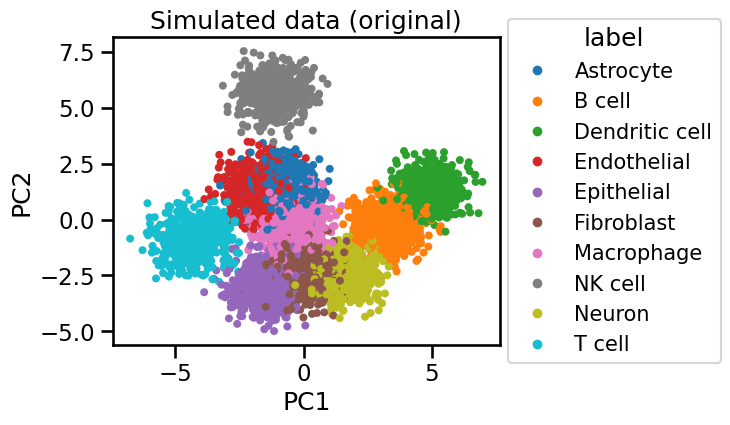

In [159]:
# plot distribtion of simulated data
old_emb = stack_embeddings(sample_df)
old_labels = sim.adata.obs["cell_type"].tolist()
plot_pca(old_emb, old_labels, title="Simulated data (original)", legend_out=True)

## 3. Initialise `MMContextEncoder` & obtain baseline embeddings

In [160]:
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
st_base = SentenceTransformer(modules=[enc]).to(DEVICE)

## 4.1 MultipleNegativesRankingLoss
The **Multiple‑Negatives Ranking Loss** treats every other sentence in the same batch as a negative example, making it memory‑efficient for large vocabularies.

*Dataset used:* **pair**

In [161]:
# --- MultipleNegativesRankingLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence1,sentence2,sample_idx
0,sample_idx:S1,Neuron,S1
1,sample_idx:S2,Fibroblast,S2
2,sample_idx:S3,Epithelial,S3
3,sample_idx:S4,NK cell,S4
4,sample_idx:S7,T cell,S7


 25%|██▌       | 16/64 [00:00<00:00, 73.28it/s]                      

{'loss': 5.1023, 'grad_norm': 4.604878902435303, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 3.8964, 'grad_norm': 3.288630723953247, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 2.9861, 'grad_norm': 1.4712027311325073, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 2.7092, 'grad_norm': 0.5605425238609314, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 2.5916, 'grad_norm': 0.1187017634510994, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 2.601, 'grad_norm': 0.09579911828041077, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 2.5786, 'grad_norm': 0.07311482727527618, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 2.5871, 'grad_norm': 0.09003212302923203, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 2.5821, 'grad_norm': 0.036566078662872314, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 2.5962, 'grad_norm': 0.041195038706064224, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 2.5685, 'grad_norm': 0.019354499876499176, 'l

 47%|████▋     | 30/64 [00:00<00:00, 72.04it/s]

{'loss': 2.591, 'grad_norm': 0.009619499556720257, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 2.5595, 'grad_norm': 0.004124698229134083, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 2.585, 'grad_norm': 0.005307122133672237, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 2.5879, 'grad_norm': 0.021970512345433235, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 2.5682, 'grad_norm': 0.004946177825331688, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 2.6246, 'grad_norm': 0.034297481179237366, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 2.6172, 'grad_norm': 0.00691950460895896, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 2.5813, 'grad_norm': 0.006277956068515778, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 2.6062, 'grad_norm': 0.0025638730730861425, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 2.5731, 'grad_norm': 0.002508056815713644, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 2.579, 'grad_norm': 0.0

 72%|███████▏  | 46/64 [00:00<00:00, 75.12it/s]

{'loss': 2.5886, 'grad_norm': 0.019627155736088753, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 1.2605, 'grad_norm': 0.002326433779671788, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 2.6081, 'grad_norm': 0.014726979658007622, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 2.5805, 'grad_norm': 0.005485054571181536, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 2.5742, 'grad_norm': 0.0023288230877369642, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 2.5882, 'grad_norm': 0.001986586721614003, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 2.5696, 'grad_norm': 0.001704842783510685, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 2.5571, 'grad_norm': 0.001915750908665359, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 2.5931, 'grad_norm': 0.0030705267563462257, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 2.5809, 'grad_norm': 0.001446777954697609, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 2.5808, 'grad_norm': 0.0009510530508123338

 97%|█████████▋| 62/64 [00:00<00:00, 76.90it/s]

{'loss': 2.576, 'grad_norm': 0.001946399686858058, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 2.5828, 'grad_norm': 0.0018888534978032112, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 2.6188, 'grad_norm': 0.0029512126930058002, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 2.6093, 'grad_norm': 0.0009072859538719058, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 2.5817, 'grad_norm': 0.0010606853757053614, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 2.5825, 'grad_norm': 0.005103910807520151, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 2.5683, 'grad_norm': 0.001250097993761301, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 2.5817, 'grad_norm': 0.005806064698845148, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 2.5949, 'grad_norm': 0.003433465724810958, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 2.5896, 'grad_norm': 0.0012656222097575665, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 2.5881, 'grad_norm': 0.0017258225707337

100%|██████████| 64/64 [00:00<00:00, 76.90it/s]

{'loss': 2.5833, 'grad_norm': 0.0009423515293747187, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 1.3006, 'grad_norm': 0.0006711228052154183, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 28.30it/s]

{'train_runtime': 2.2628, 'train_samples_per_second': 3535.46, 'train_steps_per_second': 28.284, 'train_loss': 2.6118467655032873, 'epoch': 2.0}


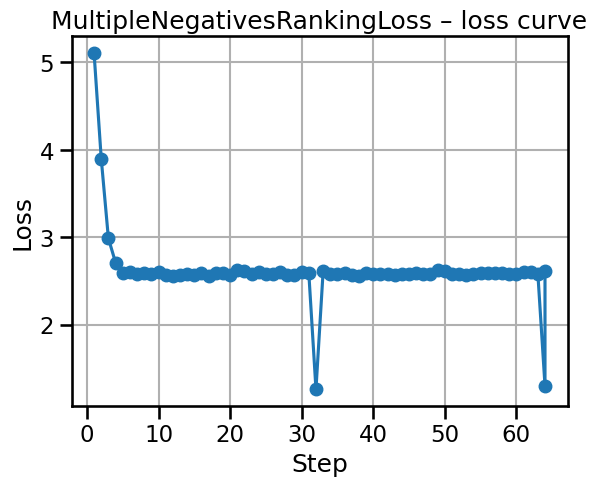

In [162]:
# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.MultipleNegativesRankingLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "multiplenegativesrankingloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="multiplenegativesrankingloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="MultipleNegativesRankingLoss – loss curve")

initial  : within=0.4910   between=0.9670
trained  : within=0.2397   between=0.8274   sil=0.718
trained2 : within=0.0000   between=0.9607


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

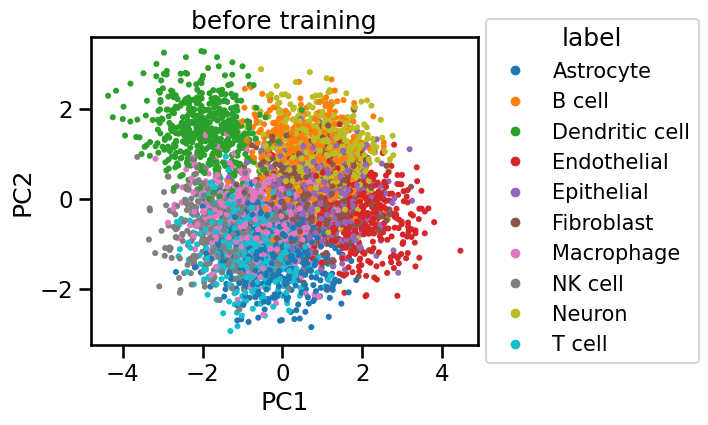

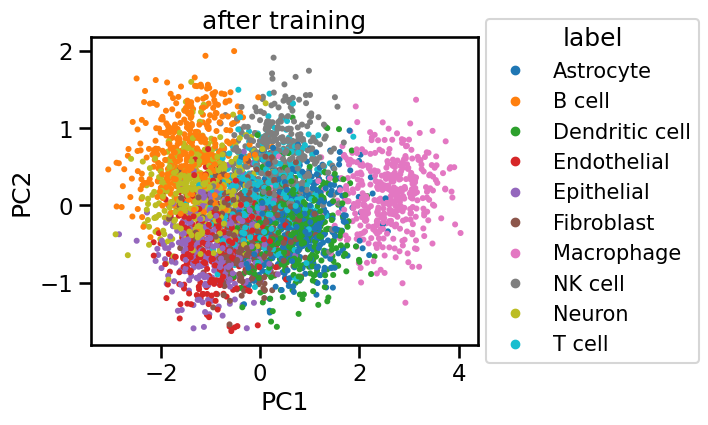

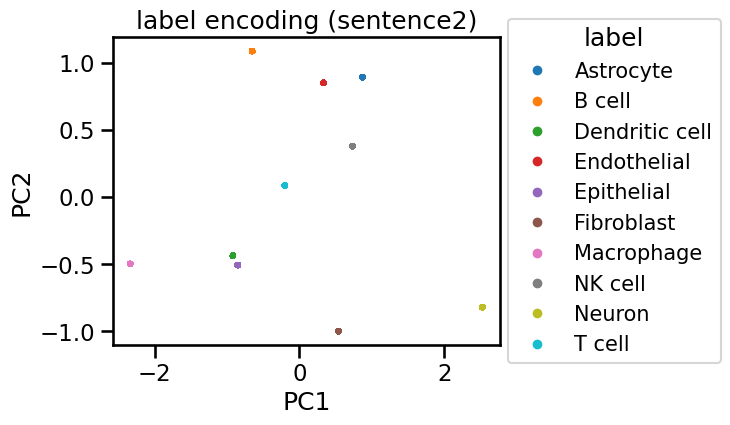

In [163]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.2 MultipleNegativesSymmetricRankingLoss
A symmetric variant that pushes both anchor→positive and positive→anchor.

*Dataset used:* **pair**

In [164]:
# --- MultipleNegativesSymmetricRankingLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence1,sentence2,sample_idx
0,sample_idx:S1,Neuron,S1
1,sample_idx:S2,Fibroblast,S2
2,sample_idx:S3,Epithelial,S3
3,sample_idx:S4,NK cell,S4
4,sample_idx:S7,T cell,S7


 25%|██▌       | 16/64 [00:00<00:00, 74.63it/s]                      

{'loss': 7.0502, 'grad_norm': 5.693477153778076, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 4.7024, 'grad_norm': 3.9106369018554688, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 3.6043, 'grad_norm': 2.465376853942871, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 2.9779, 'grad_norm': 1.0312104225158691, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 2.7407, 'grad_norm': 0.4123467803001404, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 2.7318, 'grad_norm': 0.32300159335136414, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 2.7009, 'grad_norm': 0.2783602178096771, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 2.7307, 'grad_norm': 0.31643348932266235, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 2.6771, 'grad_norm': 0.21062934398651123, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 2.6864, 'grad_norm': 0.24263954162597656, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 2.6385, 'grad_norm': 0.1783537119626999, 'learn

 50%|█████     | 32/64 [00:00<00:00, 76.06it/s]

{'loss': 2.6501, 'grad_norm': 0.18941330909729004, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 2.6537, 'grad_norm': 0.14932206273078918, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 2.6571, 'grad_norm': 0.1553920954465866, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 2.652, 'grad_norm': 0.1836967021226883, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 2.6968, 'grad_norm': 0.14601314067840576, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 2.6782, 'grad_norm': 0.14375945925712585, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 2.6458, 'grad_norm': 0.14229516685009003, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 2.6743, 'grad_norm': 0.13962559401988983, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 2.6177, 'grad_norm': 0.10872938483953476, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 2.6448, 'grad_norm': 0.13846495747566223, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 2.6506, 'grad_norm': 0.1176785

 73%|███████▎  | 47/64 [00:00<00:00, 74.93it/s]

{'loss': 2.6617, 'grad_norm': 0.12349337339401245, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 2.6232, 'grad_norm': 0.105681411921978, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 2.6137, 'grad_norm': 0.09651639312505722, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 2.6238, 'grad_norm': 0.09209781140089035, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 2.6065, 'grad_norm': 0.08961480110883713, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 2.6032, 'grad_norm': 0.10106511414051056, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 2.6267, 'grad_norm': 0.08376749604940414, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 2.6185, 'grad_norm': 0.09269788861274719, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 2.621, 'grad_norm': 0.09032683819532394, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 2.6256, 'grad_norm': 0.1073531061410904, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 2.6064, 'grad_norm': 0.09514287859201431, 'learning_r

 98%|█████████▊| 63/64 [00:00<00:00, 74.87it/s]

{'loss': 2.6299, 'grad_norm': 0.10711709409952164, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 2.6673, 'grad_norm': 0.10339081287384033, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 2.6451, 'grad_norm': 0.08522379398345947, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 2.6145, 'grad_norm': 0.08118772506713867, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 2.6137, 'grad_norm': 0.08411039412021637, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 2.6082, 'grad_norm': 0.09060144424438477, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 2.613, 'grad_norm': 0.0844179093837738, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 2.636, 'grad_norm': 0.09737694263458252, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 2.6217, 'grad_norm': 0.0788981094956398, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 2.6262, 'grad_norm': 0.09237618744373322, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 2.6299, 'grad_norm': 0.08929663151502609, 'learning_rate'

100%|██████████| 64/64 [00:00<00:00, 75.28it/s]

{'loss': 1.3252, 'grad_norm': 0.12933719158172607, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 28.01it/s]

{'train_runtime': 2.2851, 'train_samples_per_second': 3500.939, 'train_steps_per_second': 28.008, 'train_loss': 2.722823642194271, 'epoch': 2.0}


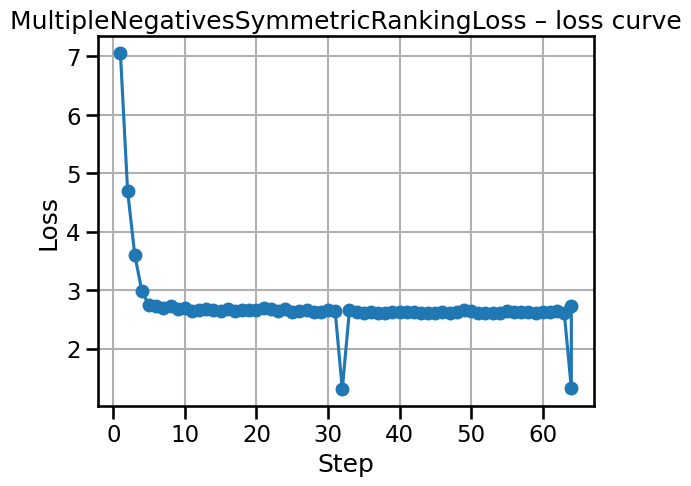

In [165]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.MultipleNegativesSymmetricRankingLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "multiplenegativessymmetricrankingloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="multiplenegativessymmetricrankingloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="MultipleNegativesSymmetricRankingLoss – loss curve")

initial  : within=0.4910   between=0.9670
trained  : within=0.2528   between=1.1109   sil=0.757
trained2 : within=0.0000   between=0.9536


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

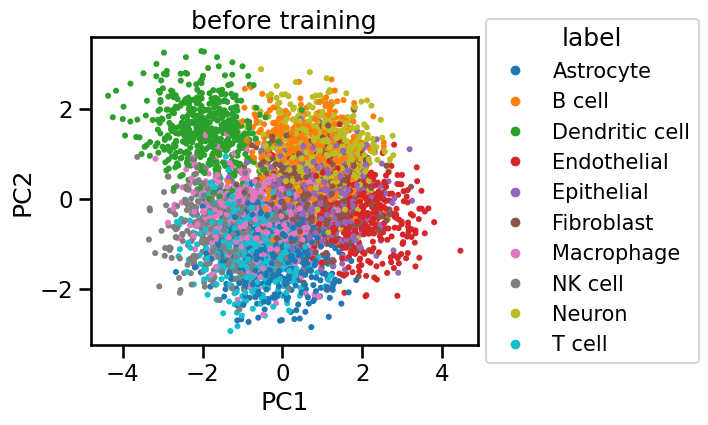

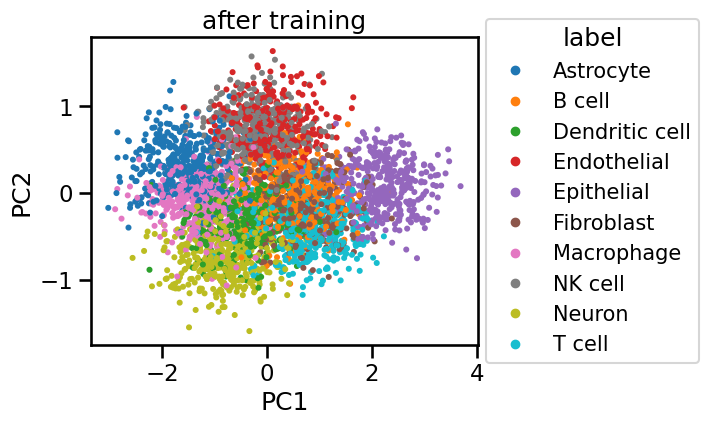

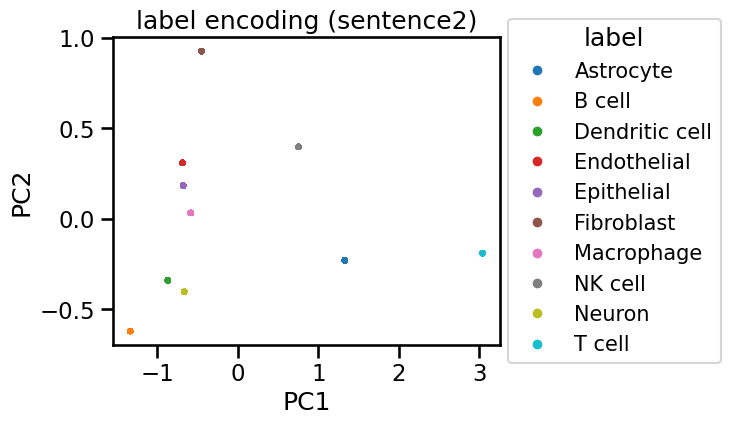

In [166]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.3 TripletLoss
Classic **triplet margin loss** with explicit anchor/positive/negative examples.

*Dataset used:* **triplet**

In [167]:
# --- TripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["triplet"]["train"]
display(pd.DataFrame(train_ds[:5]))

,anchor,positive,negative,sample_idx
0,sample_idx:S2,Fibroblast,sample_idx:S1329,S2
1,sample_idx:S3,Epithelial,sample_idx:S1852,S3
2,sample_idx:S4,NK cell,sample_idx:S3178,S4
3,sample_idx:S5,Macrophage,sample_idx:S845,S5
4,sample_idx:S6,T cell,sample_idx:S295,S6


 19%|█▉        | 12/64 [00:00<00:00, 54.00it/s]                      

{'loss': 7.9537, 'grad_norm': 2.2784907817840576, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 7.1408, 'grad_norm': 2.3362977504730225, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 5.6399, 'grad_norm': 2.3844101428985596, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 4.7192, 'grad_norm': 2.1802258491516113, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 3.974, 'grad_norm': 2.038043975830078, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 3.0281, 'grad_norm': 1.8159151077270508, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 2.5649, 'grad_norm': 1.3413357734680176, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 2.1087, 'grad_norm': 1.1916744709014893, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 2.0222, 'grad_norm': 1.0406051874160767, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 1.4015, 'grad_norm': 0.816439151763916, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 1.2928, 'grad_norm': 0.6409460306167603, 'learning_r

 38%|███▊      | 24/64 [00:00<00:00, 54.73it/s]

{'loss': 1.1617, 'grad_norm': 0.5013964772224426, 'learning_rate': 0.00796875, 'epoch': 0.41}
{'loss': 1.3195, 'grad_norm': 0.5272612571716309, 'learning_rate': 0.0078125, 'epoch': 0.44}
{'loss': 1.0698, 'grad_norm': 0.39182430505752563, 'learning_rate': 0.00765625, 'epoch': 0.47}
{'loss': 0.8692, 'grad_norm': 0.3320860266685486, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 0.9824, 'grad_norm': 0.3230242431163788, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.6816, 'grad_norm': 0.2934914529323578, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.8657, 'grad_norm': 0.3102433681488037, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.89, 'grad_norm': 0.31337782740592957, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 1.2509, 'grad_norm': 0.3950129747390747, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.8988, 'grad_norm': 0.3125983476638794, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 1.0666, 'grad_norm': 0.3139150142669678, 'learning

 58%|█████▊    | 37/64 [00:00<00:00, 61.22it/s]

{'loss': 0.9955, 'grad_norm': 0.33122745156288147, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.8367, 'grad_norm': 0.26497969031333923, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 1.0551, 'grad_norm': 0.303059458732605, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 1.1633, 'grad_norm': 0.32438915967941284, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.9984, 'grad_norm': 0.3347146213054657, 'learning_rate': 0.0054687500000000005, 'epoch': 0.91}
{'loss': 1.3986, 'grad_norm': 0.42535731196403503, 'learning_rate': 0.0053125, 'epoch': 0.94}
{'loss': 1.0044, 'grad_norm': 0.32557812333106995, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 1.4198, 'grad_norm': 0.607913076877594, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.5121, 'grad_norm': 0.20766626298427582, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.7371, 'grad_norm': 0.22870534658432007, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 0.7539, 'grad_norm': 0.25158387422561646, 'lea

 78%|███████▊  | 50/64 [00:00<00:00, 58.47it/s]

{'loss': 1.009, 'grad_norm': 0.3292471766471863, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.2265, 'grad_norm': 0.20981420576572418, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.6692, 'grad_norm': 0.2394891232252121, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.9504, 'grad_norm': 0.32886531949043274, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.8846, 'grad_norm': 0.2904786169528961, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.8223, 'grad_norm': 0.3368704319000244, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.5835, 'grad_norm': 0.2525848150253296, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.7149, 'grad_norm': 0.27850669622421265, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 0.6763, 'grad_norm': 0.2951030135154724, 'learning_rate': 0.0028125, 'epoch': 1.44}
{'loss': 0.8082, 'grad_norm': 0.3045160174369812, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 0.3382, 'grad_norm': 0.2046365737915039, 'learning_rate':

 98%|█████████▊| 63/64 [00:01<00:00, 62.31it/s]

{'loss': 0.6368, 'grad_norm': 0.2842637896537781, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.6614, 'grad_norm': 0.2551366686820984, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.7029, 'grad_norm': 0.29195842146873474, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.4833, 'grad_norm': 0.21653106808662415, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.3333, 'grad_norm': 0.20129132270812988, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.4842, 'grad_norm': 0.20890255272388458, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.5073, 'grad_norm': 0.22232256829738617, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.7726, 'grad_norm': 0.3012889325618744, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.7066, 'grad_norm': 0.272542804479599, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 0.6712, 'grad_norm': 0.25821417570114136, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 0.4056, 'grad_norm': 0.176676943898201, 'learning_rate'

100%|██████████| 64/64 [00:01<00:00, 62.31it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 25.71it/s]

{'train_runtime': 2.4908, 'train_samples_per_second': 3211.809, 'train_steps_per_second': 25.694, 'train_loss': 1.314124358119443, 'epoch': 2.0}


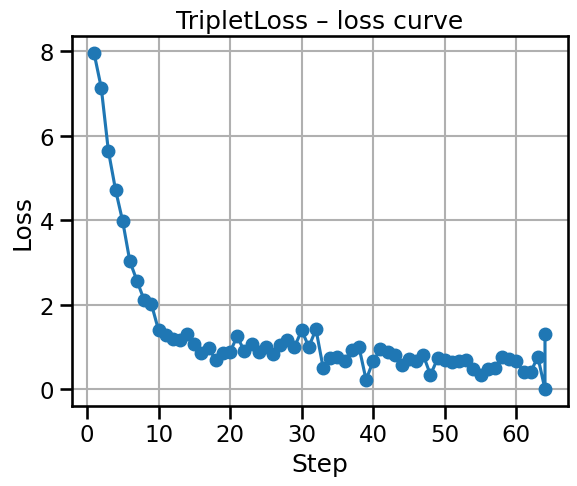

In [168]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.TripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "tripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="tripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="TripletLoss – loss curve")

initial  : within=0.4910   between=0.9670  sil=0.596
trained  : within=0.5449   between=1.9350   sil=0.738
trained2 : within=0.0000   between=0.9311  sil=1.000


<Axes: title={'center': 'label encoding (positive)'}, xlabel='PC1', ylabel='PC2'>

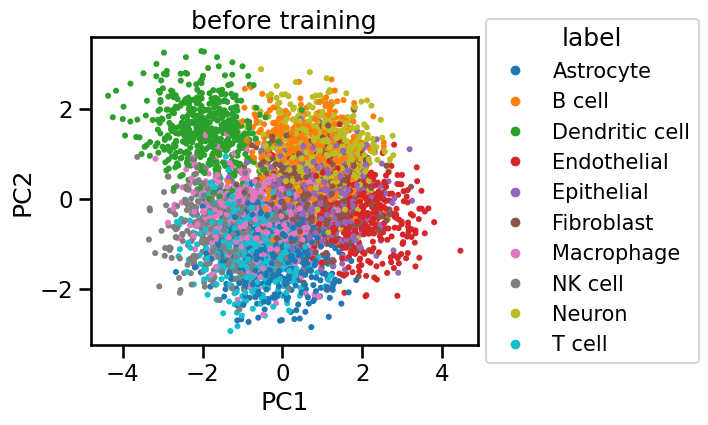

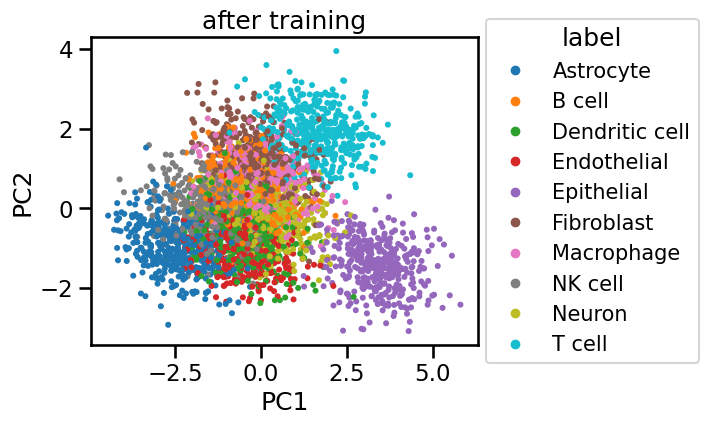

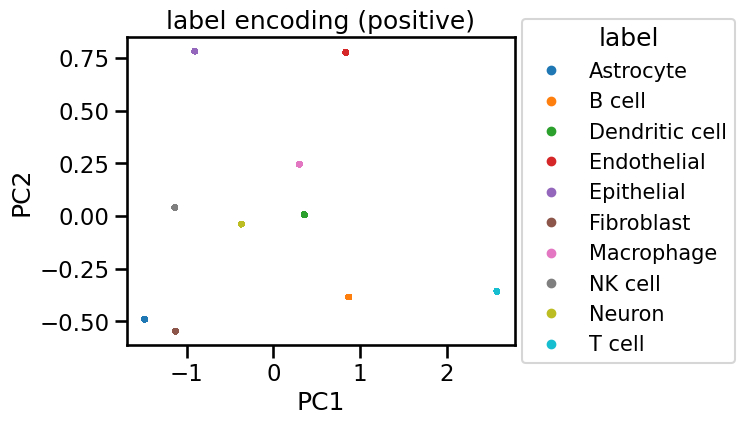

In [169]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset triplet")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["positive"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}  sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}  sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (positive)", point_size=8, legend_out=True)

## 4.4 ContrastiveLoss
Binary‑label contrastive loss (1 = similar, 0 = dissimilar) originally from Hadsell et al., 2006.

*Dataset used:* **pair-binary**

In [170]:
# --- ContrastiveLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair-binary"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence1,sentence2,label,sample_idx
0,sample_idx:S1,Neuron,1,S1
1,sample_idx:S1,T cell,0,S1
2,sample_idx:S2,Fibroblast,1,S2
3,sample_idx:S2,Dendritic cell,0,S2
4,sample_idx:S4,NK cell,1,S4


{'loss': 0.257, 'grad_norm': 0.12664780020713806, 'learning_rate': 0.009920634920634922, 'epoch': 0.02}
{'loss': 0.238, 'grad_norm': 0.12373645603656769, 'learning_rate': 0.009841269841269842, 'epoch': 0.03}
{'loss': 0.1624, 'grad_norm': 0.09733976423740387, 'learning_rate': 0.009761904761904762, 'epoch': 0.05}
{'loss': 0.1705, 'grad_norm': 0.09658094495534897, 'learning_rate': 0.009682539682539683, 'epoch': 0.06}
{'loss': 0.1119, 'grad_norm': 0.070649653673172, 'learning_rate': 0.009603174603174603, 'epoch': 0.08}
{'loss': 0.0984, 'grad_norm': 0.06048736721277237, 'learning_rate': 0.009523809523809523, 'epoch': 0.1}
{'loss': 0.083, 'grad_norm': 0.05330272391438484, 'learning_rate': 0.009444444444444445, 'epoch': 0.11}
{'loss': 0.0586, 'grad_norm': 0.04059164971113205, 'learning_rate': 0.009365079365079366, 'epoch': 0.13}
{'loss': 0.0559, 'grad_norm': 0.03724880889058113, 'learning_rate': 0.009285714285714286, 'epoch': 0.14}
{'loss': 0.0464, 'grad_norm': 0.032128382474184036, 'learning

 25%|██▍       | 31/126 [00:00<00:01, 74.32it/s]

{'loss': 0.0214, 'grad_norm': 0.014231650158762932, 'learning_rate': 0.00873015873015873, 'epoch': 0.25}
{'loss': 0.0187, 'grad_norm': 0.01062705647200346, 'learning_rate': 0.008650793650793652, 'epoch': 0.27}
{'loss': 0.0164, 'grad_norm': 0.009600761346518993, 'learning_rate': 0.008571428571428572, 'epoch': 0.29}
{'loss': 0.0172, 'grad_norm': 0.009268540889024734, 'learning_rate': 0.008492063492063492, 'epoch': 0.3}
{'loss': 0.0162, 'grad_norm': 0.009654391556978226, 'learning_rate': 0.008412698412698413, 'epoch': 0.32}
{'loss': 0.0157, 'grad_norm': 0.008038685657083988, 'learning_rate': 0.008333333333333333, 'epoch': 0.33}
{'loss': 0.0145, 'grad_norm': 0.007433469407260418, 'learning_rate': 0.008253968253968253, 'epoch': 0.35}
{'loss': 0.0135, 'grad_norm': 0.006922707427293062, 'learning_rate': 0.008174603174603175, 'epoch': 0.37}
{'loss': 0.0144, 'grad_norm': 0.007079857401549816, 'learning_rate': 0.008095238095238096, 'epoch': 0.38}
{'loss': 0.0117, 'grad_norm': 0.00541931111365556

 37%|███▋      | 46/126 [00:00<00:01, 76.34it/s]

{'loss': 0.0106, 'grad_norm': 0.004708432126790285, 'learning_rate': 0.00753968253968254, 'epoch': 0.49}
{'loss': 0.0103, 'grad_norm': 0.004192676395177841, 'learning_rate': 0.0074603174603174605, 'epoch': 0.51}
{'loss': 0.0104, 'grad_norm': 0.004889353644102812, 'learning_rate': 0.007380952380952381, 'epoch': 0.52}
{'loss': 0.0112, 'grad_norm': 0.00490081962198019, 'learning_rate': 0.007301587301587301, 'epoch': 0.54}
{'loss': 0.0094, 'grad_norm': 0.004725764039903879, 'learning_rate': 0.007222222222222222, 'epoch': 0.56}
{'loss': 0.0123, 'grad_norm': 0.006141289137303829, 'learning_rate': 0.0071428571428571435, 'epoch': 0.57}
{'loss': 0.012, 'grad_norm': 0.005115789361298084, 'learning_rate': 0.007063492063492064, 'epoch': 0.59}
{'loss': 0.0096, 'grad_norm': 0.004606279544532299, 'learning_rate': 0.006984126984126984, 'epoch': 0.6}
{'loss': 0.0132, 'grad_norm': 0.005039687734097242, 'learning_rate': 0.006904761904761905, 'epoch': 0.62}
{'loss': 0.011, 'grad_norm': 0.00401687202975153

 48%|████▊     | 61/126 [00:00<00:00, 74.17it/s]

{'loss': 0.0076, 'grad_norm': 0.003803893690928817, 'learning_rate': 0.00626984126984127, 'epoch': 0.75}
{'loss': 0.0111, 'grad_norm': 0.0039644185453653336, 'learning_rate': 0.006190476190476191, 'epoch': 0.76}
{'loss': 0.0078, 'grad_norm': 0.0033083786256611347, 'learning_rate': 0.006111111111111111, 'epoch': 0.78}
{'loss': 0.0099, 'grad_norm': 0.003599035320803523, 'learning_rate': 0.006031746031746031, 'epoch': 0.79}
{'loss': 0.0092, 'grad_norm': 0.0047477190382778645, 'learning_rate': 0.005952380952380952, 'epoch': 0.81}
{'loss': 0.0082, 'grad_norm': 0.0033401125110685825, 'learning_rate': 0.005873015873015874, 'epoch': 0.83}
{'loss': 0.0089, 'grad_norm': 0.004052197095006704, 'learning_rate': 0.005793650793650794, 'epoch': 0.84}
{'loss': 0.011, 'grad_norm': 0.004184741992503405, 'learning_rate': 0.005714285714285714, 'epoch': 0.86}
{'loss': 0.009, 'grad_norm': 0.0030540188308805227, 'learning_rate': 0.005634920634920635, 'epoch': 0.87}
{'loss': 0.0086, 'grad_norm': 0.003053093096

{'loss': 0.0101, 'grad_norm': 0.0035247690975666046, 'learning_rate': 0.005079365079365079, 'epoch': 0.98}
{'loss': 0.0069, 'grad_norm': 0.004781661089509726, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.0126, 'grad_norm': 0.003875095397233963, 'learning_rate': 0.004920634920634921, 'epoch': 1.02}
{'loss': 0.0105, 'grad_norm': 0.0038517373614013195, 'learning_rate': 0.004841269841269842, 'epoch': 1.03}
{'loss': 0.0086, 'grad_norm': 0.0035018741618841887, 'learning_rate': 0.0047619047619047615, 'epoch': 1.05}
{'loss': 0.0109, 'grad_norm': 0.003224363084882498, 'learning_rate': 0.004682539682539683, 'epoch': 1.06}
{'loss': 0.0072, 'grad_norm': 0.003184795379638672, 'learning_rate': 0.004603174603174603, 'epoch': 1.08}
{'loss': 0.0076, 'grad_norm': 0.0030856637749820948, 'learning_rate': 0.004523809523809524, 'epoch': 1.1}
{'loss': 0.0077, 'grad_norm': 0.0034418844152241945, 'learning_rate': 0.0044444444444444444, 'epoch': 1.11}
{'loss': 0.0126, 'grad_norm': 0.003864716272801161, 'lea

{'loss': 0.0083, 'grad_norm': 0.00385479093529284, 'learning_rate': 0.003968253968253968, 'epoch': 1.21}
{'loss': 0.0085, 'grad_norm': 0.0033167239744216204, 'learning_rate': 0.003888888888888889, 'epoch': 1.22}
{'loss': 0.0056, 'grad_norm': 0.0030701763462275267, 'learning_rate': 0.0038095238095238095, 'epoch': 1.24}
{'loss': 0.0062, 'grad_norm': 0.0027906973846256733, 'learning_rate': 0.0037301587301587303, 'epoch': 1.25}
{'loss': 0.0078, 'grad_norm': 0.003403682028874755, 'learning_rate': 0.0036507936507936506, 'epoch': 1.27}
{'loss': 0.0075, 'grad_norm': 0.0028185483533889055, 'learning_rate': 0.0035714285714285718, 'epoch': 1.29}
{'loss': 0.0075, 'grad_norm': 0.003494016360491514, 'learning_rate': 0.003492063492063492, 'epoch': 1.3}
{'loss': 0.0087, 'grad_norm': 0.0033283161465078592, 'learning_rate': 0.003412698412698413, 'epoch': 1.32}
{'loss': 0.0093, 'grad_norm': 0.0026735225692391396, 'learning_rate': 0.003333333333333333, 'epoch': 1.33}
{'loss': 0.0087, 'grad_norm': 0.003797

 85%|████████▍ | 107/126 [00:01<00:00, 76.10it/s]

{'loss': 0.008, 'grad_norm': 0.0030287818517535925, 'learning_rate': 0.002698412698412698, 'epoch': 1.46}
{'loss': 0.0068, 'grad_norm': 0.003281078999862075, 'learning_rate': 0.0026190476190476194, 'epoch': 1.48}
{'loss': 0.0091, 'grad_norm': 0.002991237910464406, 'learning_rate': 0.0025396825396825397, 'epoch': 1.49}
{'loss': 0.0067, 'grad_norm': 0.003108666045591235, 'learning_rate': 0.0024603174603174604, 'epoch': 1.51}
{'loss': 0.0089, 'grad_norm': 0.003393756225705147, 'learning_rate': 0.0023809523809523807, 'epoch': 1.52}
{'loss': 0.0077, 'grad_norm': 0.003054863540455699, 'learning_rate': 0.0023015873015873015, 'epoch': 1.54}
{'loss': 0.007, 'grad_norm': 0.0028520911000669003, 'learning_rate': 0.0022222222222222222, 'epoch': 1.56}
{'loss': 0.0072, 'grad_norm': 0.002614969154819846, 'learning_rate': 0.002142857142857143, 'epoch': 1.57}
{'loss': 0.0095, 'grad_norm': 0.0033043979201465845, 'learning_rate': 0.0020634920634920633, 'epoch': 1.59}
{'loss': 0.0074, 'grad_norm': 0.003374

 98%|█████████▊| 123/126 [00:01<00:00, 75.41it/s]

{'loss': 0.009, 'grad_norm': 0.0030387002043426037, 'learning_rate': 0.0014285714285714286, 'epoch': 1.71}
{'loss': 0.0084, 'grad_norm': 0.0034012559335678816, 'learning_rate': 0.001349206349206349, 'epoch': 1.73}
{'loss': 0.0092, 'grad_norm': 0.00399918993934989, 'learning_rate': 0.0012698412698412698, 'epoch': 1.75}
{'loss': 0.0088, 'grad_norm': 0.0031140611972659826, 'learning_rate': 0.0011904761904761904, 'epoch': 1.76}
{'loss': 0.0065, 'grad_norm': 0.002481450093910098, 'learning_rate': 0.0011111111111111111, 'epoch': 1.78}
{'loss': 0.0099, 'grad_norm': 0.0030232786666601896, 'learning_rate': 0.0010317460317460316, 'epoch': 1.79}
{'loss': 0.0092, 'grad_norm': 0.003171308431774378, 'learning_rate': 0.0009523809523809524, 'epoch': 1.81}
{'loss': 0.008, 'grad_norm': 0.002910810289904475, 'learning_rate': 0.000873015873015873, 'epoch': 1.83}
{'loss': 0.008, 'grad_norm': 0.0030891362112015486, 'learning_rate': 0.0007936507936507937, 'epoch': 1.84}
{'loss': 0.0113, 'grad_norm': 0.003058

100%|██████████| 126/126 [00:01<00:00, 75.41it/s]

{'loss': 0.0062, 'grad_norm': 0.0032966795843094587, 'learning_rate': 0.00015873015873015873, 'epoch': 1.97}
{'loss': 0.0078, 'grad_norm': 0.0040419683791697025, 'learning_rate': 7.936507936507937e-05, 'epoch': 1.98}
{'loss': 0.0066, 'grad_norm': 0.0038659009151160717, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 126/126 [00:03<00:00, 39.59it/s]

{'train_runtime': 3.1843, 'train_samples_per_second': 5024.629, 'train_steps_per_second': 39.569, 'train_loss': 0.019996583199365033, 'epoch': 2.0}


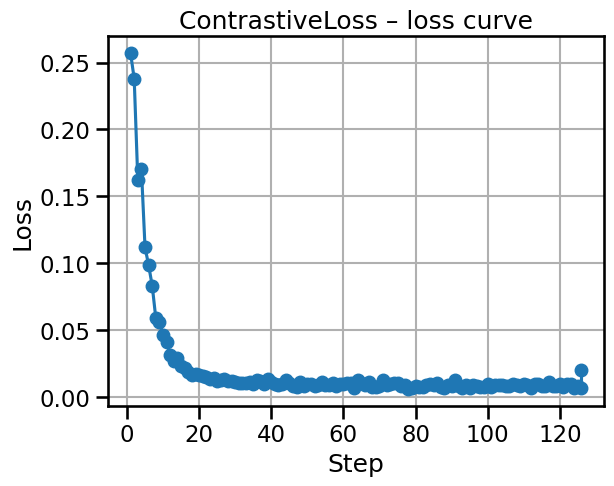

In [171]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)


# Pick loss class dynamically
loss_cls = losses.ContrastiveLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "contrastiveloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="contrastiveloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="ContrastiveLoss – loss curve")

initial  : within=0.4910   between=0.9670 sil=0.596
trained  : within=0.2838   between=1.2052   sil=0.769
trained2 : within=0.7079   between=0.2430  sil=0.036


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

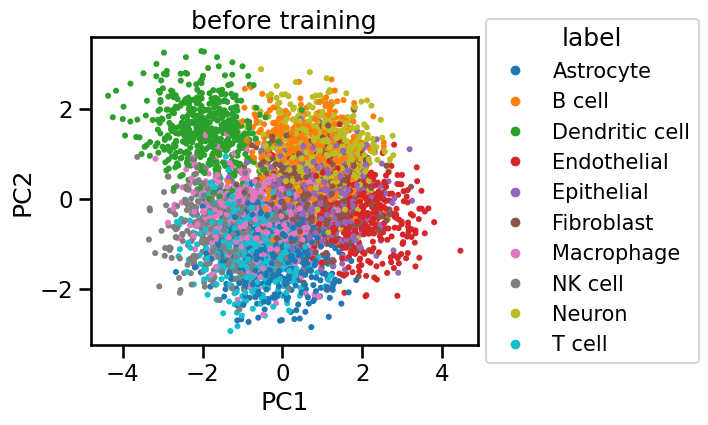

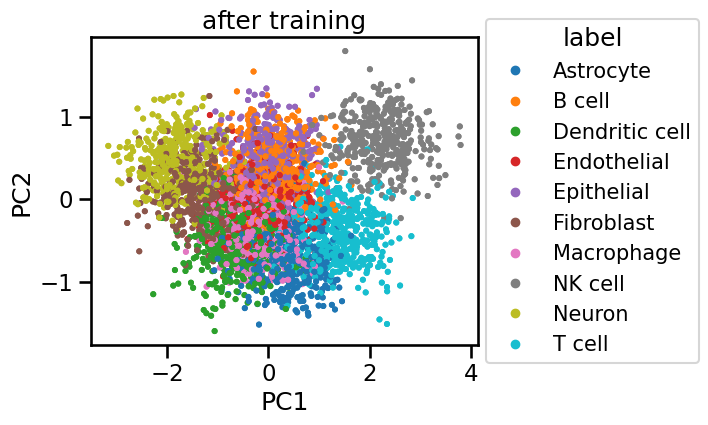

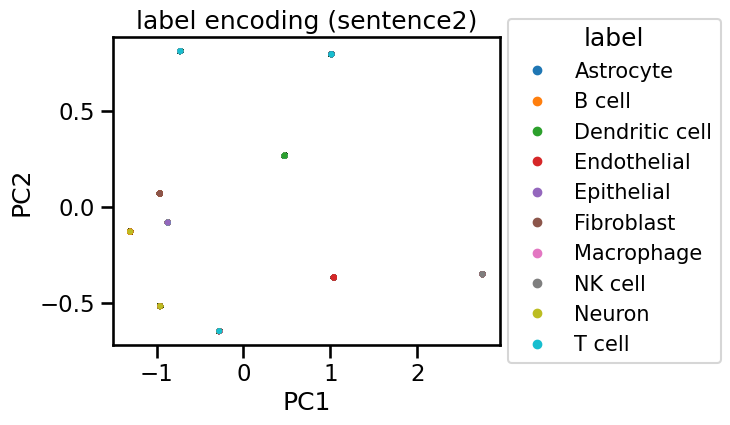

In [172]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair-binary")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}  sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.5 BatchAllTripletLoss
Generates *all* valid triplets in a batch and averages over them.

*Dataset used:* **single-class**

In [173]:
# --- BatchAllTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence,label,sample_idx
0,sample_idx:S1,8,S1
1,sample_idx:S2,5,S2
2,sample_idx:S3,4,S3
3,sample_idx:S5,6,S5
4,sample_idx:S6,9,S6


 14%|█▍        | 9/64 [00:00<00:01, 37.73it/s]                       

{'loss': 1.3089, 'grad_norm': 2.1188323497772217, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 1.142, 'grad_norm': 1.939295768737793, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 1.064, 'grad_norm': 1.8291586637496948, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.9371, 'grad_norm': 1.9968262910842896, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.9031, 'grad_norm': 1.6845643520355225, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 1.0259, 'grad_norm': 2.039938449859619, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.962, 'grad_norm': 2.260955810546875, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.9009, 'grad_norm': 1.9272029399871826, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 1.1695, 'grad_norm': 2.110978841781616, 'learning_rate': 0.00859375, 'epoch': 0.28}


 30%|██▉       | 19/64 [00:00<00:01, 42.60it/s]

{'loss': 0.884, 'grad_norm': 1.784824252128601, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.9601, 'grad_norm': 2.699451446533203, 'learning_rate': 0.00828125, 'epoch': 0.34}
{'loss': 0.908, 'grad_norm': 2.0951426029205322, 'learning_rate': 0.008125, 'epoch': 0.38}
{'loss': 1.1539, 'grad_norm': 2.6980459690093994, 'learning_rate': 0.00796875, 'epoch': 0.41}
{'loss': 1.0898, 'grad_norm': 2.7009592056274414, 'learning_rate': 0.0078125, 'epoch': 0.44}
{'loss': 1.1947, 'grad_norm': 2.442680835723877, 'learning_rate': 0.00765625, 'epoch': 0.47}
{'loss': 1.8327, 'grad_norm': 2.738255500793457, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 1.1323, 'grad_norm': 2.3862879276275635, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 1.613, 'grad_norm': 2.9440038204193115, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 1.5028, 'grad_norm': 2.7931036949157715, 'learning_rate': 0.00703125, 'epoch': 0.59}


 44%|████▍     | 28/64 [00:00<00:00, 42.65it/s]

{'loss': 1.1943, 'grad_norm': 2.8141982555389404, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 1.2945, 'grad_norm': 2.3412606716156006, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 1.3512, 'grad_norm': 2.72584867477417, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.7978, 'grad_norm': 2.582669496536255, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 1.2353, 'grad_norm': 2.3636739253997803, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 1.3387, 'grad_norm': 2.5187032222747803, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 1.1299, 'grad_norm': 3.1903984546661377, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 1.1227, 'grad_norm': 2.794316053390503, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.9963, 'grad_norm': 2.261908531188965, 'learning_rate': 0.005625, 'epoch': 0.88}


 59%|█████▉    | 38/64 [00:00<00:00, 46.06it/s]

{'loss': 1.3143, 'grad_norm': 2.740169048309326, 'learning_rate': 0.0054687500000000005, 'epoch': 0.91}
{'loss': 0.9727, 'grad_norm': 3.5142080783843994, 'learning_rate': 0.0053125, 'epoch': 0.94}
{'loss': 1.2084, 'grad_norm': 3.104661703109741, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 0.762, 'grad_norm': 6.638859748840332, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 1.1834, 'grad_norm': 2.3421952724456787, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 1.356, 'grad_norm': 3.927053213119507, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 1.1157, 'grad_norm': 2.2858822345733643, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 1.4931, 'grad_norm': 2.4097251892089844, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 1.7414, 'grad_norm': 4.42399263381958, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.7879, 'grad_norm': 2.8953819274902344, 'learning_rate': 0.0040625, 'epoch': 1.19}


 75%|███████▌  | 48/64 [00:01<00:00, 46.47it/s]

{'loss': 1.3102, 'grad_norm': 2.8501594066619873, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 1.1918, 'grad_norm': 2.7015738487243652, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 1.2014, 'grad_norm': 2.9422671794891357, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 1.7677, 'grad_norm': 3.690617799758911, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 1.457, 'grad_norm': 3.6775190830230713, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.7567, 'grad_norm': 2.9278528690338135, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 1.4276, 'grad_norm': 3.2619071006774902, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 1.2089, 'grad_norm': 3.335341691970825, 'learning_rate': 0.0028125, 'epoch': 1.44}
{'loss': 1.0712, 'grad_norm': 2.671415328979492, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 1.7255, 'grad_norm': 2.867096424102783, 'learning_rate': 0.0025, 'epoch': 1.5}


 91%|█████████ | 58/64 [00:01<00:00, 47.66it/s]

{'loss': 1.8483, 'grad_norm': 3.6591875553131104, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 1.6797, 'grad_norm': 2.36354660987854, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 1.1404, 'grad_norm': 3.1991162300109863, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.87, 'grad_norm': 2.802870988845825, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.8349, 'grad_norm': 4.660909175872803, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.9099, 'grad_norm': 3.7451889514923096, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 1.2128, 'grad_norm': 2.5358965396881104, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 1.017, 'grad_norm': 3.6873083114624023, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 1.4144, 'grad_norm': 3.8149917125701904, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 1.2639, 'grad_norm': 2.679323196411133, 'learning_rate': 0.0009375, 'epoch': 1.81}


100%|██████████| 64/64 [00:01<00:00, 48.33it/s]

{'loss': 1.0978, 'grad_norm': 3.086303472518921, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 1.4068, 'grad_norm': 2.81258225440979, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 1.3708, 'grad_norm': 3.0534586906433105, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 1.9886, 'grad_norm': 4.1675920486450195, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 1.0648, 'grad_norm': 4.689423561096191, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 21.82it/s]

{'train_runtime': 2.9349, 'train_samples_per_second': 2725.847, 'train_steps_per_second': 21.807, 'train_loss': 1.1924732364714146, 'epoch': 2.0}


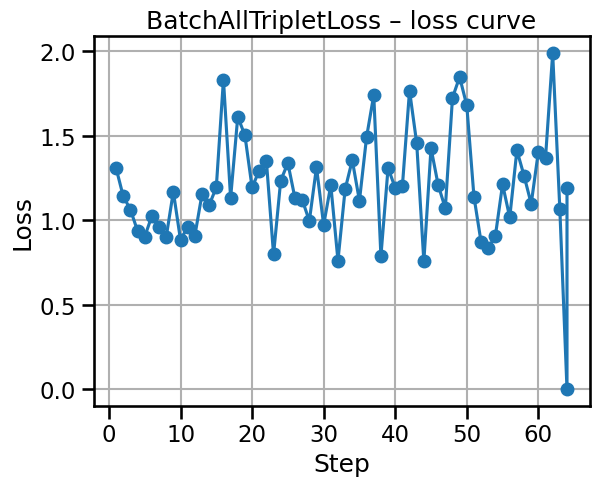

In [174]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchAllTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchalltripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchalltripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="BatchAllTripletLoss – loss curve")

initial  : within=0.4910   between=0.9670 sil=0.596
trained  : within=0.4734   between=3.0446   sil=0.838


<Axes: title={'center': 'after training'}, xlabel='PC1', ylabel='PC2'>

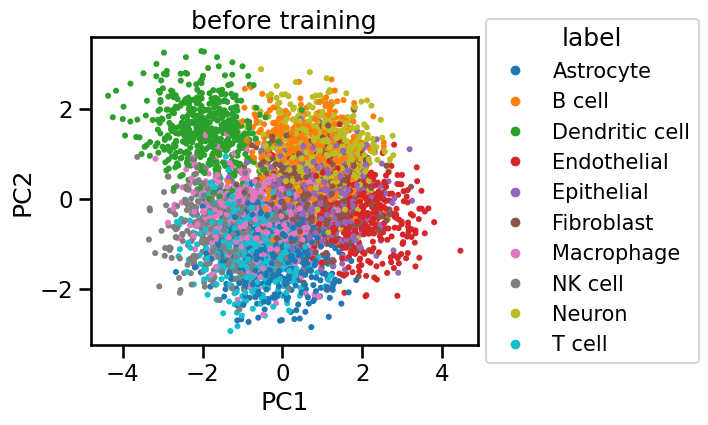

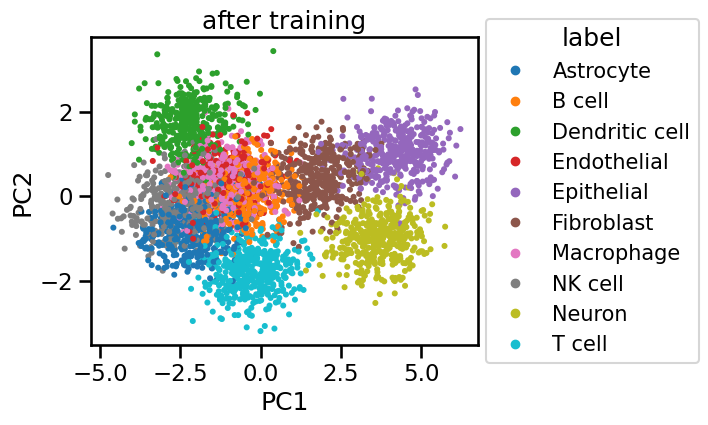

In [175]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)

## 4.6 BatchHardTripletLoss
Selects hardest positive & negative per anchor in batch (faceNet style).

*Dataset used:* **single-class**

In [176]:
# --- BatchHardTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence,label,sample_idx
0,sample_idx:S1,8,S1
1,sample_idx:S2,5,S2
2,sample_idx:S3,4,S3
3,sample_idx:S5,6,S5
4,sample_idx:S6,9,S6


{'loss': 4.2469, 'grad_norm': 2.0412697792053223, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 3.7078, 'grad_norm': 1.894055724143982, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 3.2958, 'grad_norm': 1.9453774690628052, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 2.5935, 'grad_norm': 1.9859600067138672, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 2.2545, 'grad_norm': 1.8059277534484863, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 2.3175, 'grad_norm': 1.861613392829895, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 1.5142, 'grad_norm': 1.5991923809051514, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 1.5302, 'grad_norm': 1.669190526008606, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 1.6897, 'grad_norm': 1.5423829555511475, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 1.1085, 'grad_norm': 1.2422772645950317, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.9898, 'grad_norm': 1.3949110507965088, 'learning_r

 53%|█████▎    | 34/64 [00:00<00:00, 83.05it/s]

{'loss': 1.1023, 'grad_norm': 1.2264751195907593, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.6527, 'grad_norm': 0.9240810871124268, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.8709, 'grad_norm': 0.9720312356948853, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.5931, 'grad_norm': 0.7848642468452454, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.4822, 'grad_norm': 0.7960060834884644, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.6538, 'grad_norm': 0.8933934569358826, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.6331, 'grad_norm': 0.7366153597831726, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.3794, 'grad_norm': 0.669540286064148, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.4435, 'grad_norm': 0.6962438225746155, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.5773, 'grad_norm': 0.6809285283088684, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.4983, 'grad_norm': 0.5942808985710144, 'learning

 77%|███████▋  | 49/64 [00:00<00:00, 76.84it/s]

{'loss': 0.6037, 'grad_norm': 0.6905055642127991, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 0.6723, 'grad_norm': 0.6630420684814453, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.3916, 'grad_norm': 0.6992407441139221, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.2214, 'grad_norm': 0.494310587644577, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.3465, 'grad_norm': 0.5099917054176331, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.3639, 'grad_norm': 0.5501702427864075, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.2654, 'grad_norm': 0.41265296936035156, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.386, 'grad_norm': 0.591009795665741, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.3573, 'grad_norm': 0.5088961720466614, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.2904, 'grad_norm': 0.5231350660324097, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.3654, 'grad_norm': 0.5335531830787659, 'learning_rate': 0.00

100%|██████████| 64/64 [00:00<00:00, 77.02it/s]

{'loss': 0.6954, 'grad_norm': 0.7183762788772583, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.3294, 'grad_norm': 0.6192027926445007, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.2316, 'grad_norm': 0.3700331151485443, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.1106, 'grad_norm': 0.37808507680892944, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.1557, 'grad_norm': 0.31981924176216125, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.5117, 'grad_norm': 0.6816127300262451, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.2141, 'grad_norm': 0.4574548006057739, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.2967, 'grad_norm': 0.5138387680053711, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.4708, 'grad_norm': 0.5901515483856201, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.2843, 'grad_norm': 0.5779674649238586, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 0.4366, 'grad_norm': 0.585703432559967, 'learning_rate': 

100%|██████████| 64/64 [00:02<00:00, 27.42it/s]

{'train_runtime': 2.3356, 'train_samples_per_second': 3425.31, 'train_steps_per_second': 27.402, 'train_loss': 0.7896980595542118, 'epoch': 2.0}


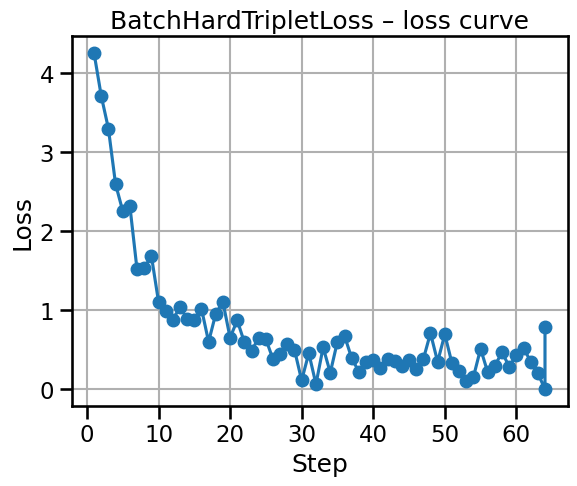

In [177]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchHardTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchhardtripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchhardtripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="BatchHardTripletLoss – loss curve")

initial  : within=0.4910   between=0.9670 sil=0.596
trained  : within=0.3900   between=2.5432   sil=0.841


<Axes: title={'center': 'after training'}, xlabel='PC1', ylabel='PC2'>

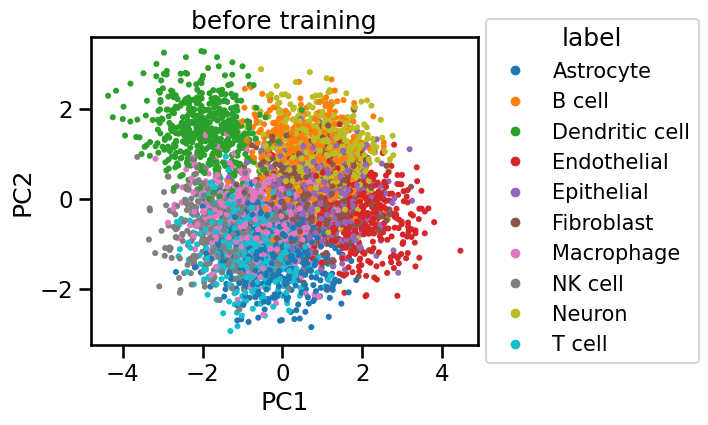

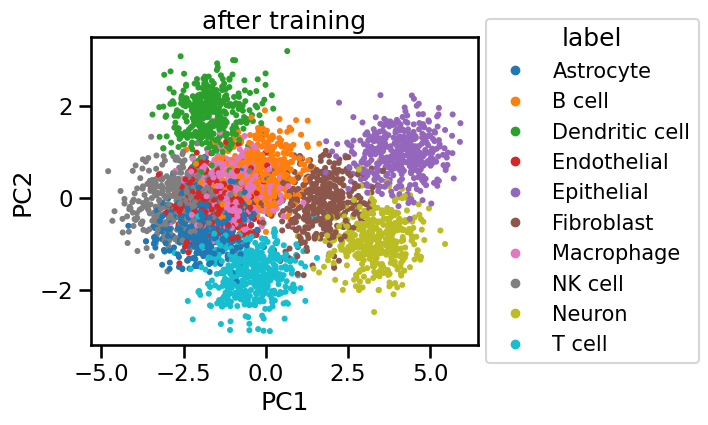

In [178]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)


print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)

## 4.7 BatchSemiHardTripletLoss
Like ‘hard’ but excludes positives that are further away than the hardest negatives.

*Dataset used:* **single-class**

In [179]:
# --- BatchSemiHardTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence,label,sample_idx
0,sample_idx:S1,8,S1
1,sample_idx:S2,5,S2
2,sample_idx:S3,4,S3
3,sample_idx:S5,6,S5
4,sample_idx:S6,9,S6


 23%|██▎       | 15/64 [00:00<00:00, 65.57it/s]                      

{'loss': 2.9274, 'grad_norm': 1.8948606252670288, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 2.4114, 'grad_norm': 1.7843886613845825, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 1.9372, 'grad_norm': 1.7680225372314453, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 1.2467, 'grad_norm': 1.7620408535003662, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.978, 'grad_norm': 1.196977138519287, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 1.0834, 'grad_norm': 1.3880841732025146, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.4426, 'grad_norm': 0.7494303584098816, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.4213, 'grad_norm': 0.7101009488105774, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.4565, 'grad_norm': 0.5925362706184387, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.2615, 'grad_norm': 0.42363449931144714, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.2086, 'grad_norm': 0.4609905481338501, 'learning

 48%|████▊     | 31/64 [00:00<00:00, 71.79it/s]

{'loss': 0.2613, 'grad_norm': 0.35638079047203064, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 0.1642, 'grad_norm': 0.27128177881240845, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.2461, 'grad_norm': 0.35438892245292664, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.3172, 'grad_norm': 0.46290600299835205, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.1342, 'grad_norm': 0.2549368441104889, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.223, 'grad_norm': 0.32516053318977356, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.1216, 'grad_norm': 0.2095651626586914, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.075, 'grad_norm': 0.1707851141691208, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.1613, 'grad_norm': 0.2650095224380493, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.16, 'grad_norm': 0.274000346660614, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.0682, 'grad_norm': 0.178501695394516, '

 73%|███████▎  | 47/64 [00:00<00:00, 75.76it/s]

{'loss': 0.0144, 'grad_norm': 0.10963539779186249, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.1177, 'grad_norm': 0.2048177719116211, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.0572, 'grad_norm': 0.14370892941951752, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 0.1138, 'grad_norm': 0.20039892196655273, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 0.1458, 'grad_norm': 0.19613540172576904, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.0803, 'grad_norm': 0.17693555355072021, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.0311, 'grad_norm': 0.09549584984779358, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0517, 'grad_norm': 0.10092329978942871, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.0805, 'grad_norm': 0.13755914568901062, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0417, 'grad_norm': 0.11217998713254929, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0819, 'grad_norm': 0.14166177809238434, 'learning_rat

 98%|█████████▊| 63/64 [00:00<00:00, 76.68it/s]

{'loss': 0.1548, 'grad_norm': 0.21556149423122406, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 0.066, 'grad_norm': 0.11927028745412827, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.1746, 'grad_norm': 0.20877636969089508, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.0711, 'grad_norm': 0.17912395298480988, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.0317, 'grad_norm': 0.08805118501186371, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.017, 'grad_norm': 0.07474230974912643, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.0149, 'grad_norm': 0.05141212418675423, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.0729, 'grad_norm': 0.13734258711338043, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.032, 'grad_norm': 0.10977278649806976, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.0405, 'grad_norm': 0.09445341676473618, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.0975, 'grad_norm': 0.1524069607257843, 'learning_rate'

100%|██████████| 64/64 [00:00<00:00, 76.68it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:01<00:00, 32.31it/s]

{'train_runtime': 1.9823, 'train_samples_per_second': 4035.655, 'train_steps_per_second': 32.285, 'train_loss': 0.27923818182898685, 'epoch': 2.0}


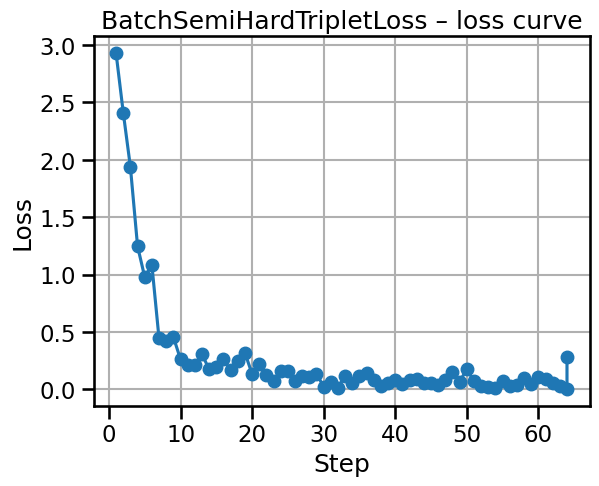

In [180]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchSemiHardTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchsemihardtripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchsemihardtripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="BatchSemiHardTripletLoss – loss curve")

initial  : within=0.4910   between=0.9670  sil=0.596
trained  : within=0.3822   between=2.3816   sil=0.836


<Axes: title={'center': 'after training'}, xlabel='PC1', ylabel='PC2'>

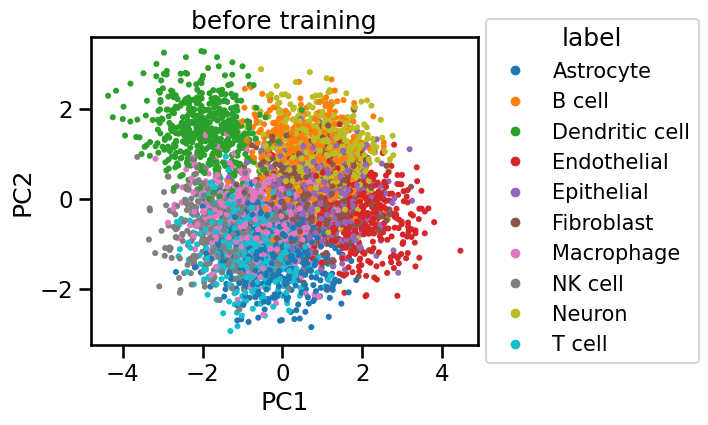

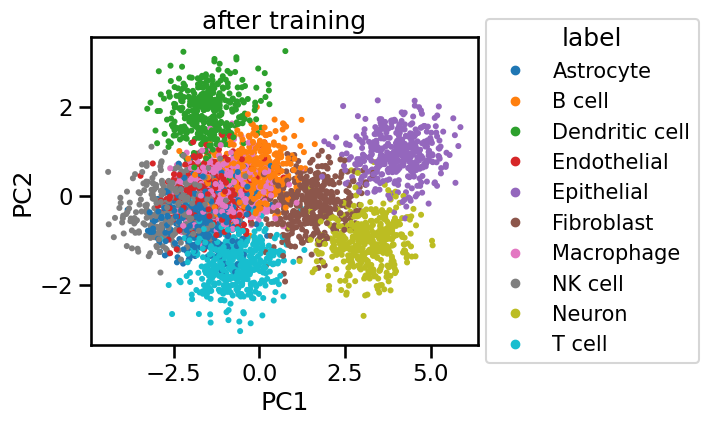

In [181]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}  sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)

## 4.8 BatchHardSoftMarginTripletLoss
Hard triplet mining combined with a soft‑margin formulation.

*Dataset used:* **single-class**

In [182]:
# --- BatchHardSoftMarginTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

,sentence,label,sample_idx
0,sample_idx:S1,8,S1
1,sample_idx:S2,5,S2
2,sample_idx:S3,4,S3
3,sample_idx:S5,6,S5
4,sample_idx:S6,9,S6


 30%|██▉       | 19/64 [00:00<00:00, 91.41it/s]                      

{'loss': 0.4925, 'grad_norm': 0.7178006172180176, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 0.3644, 'grad_norm': 0.6040143966674805, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 0.2681, 'grad_norm': 0.46179258823394775, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.1589, 'grad_norm': 0.28794488310813904, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.1182, 'grad_norm': 0.1982675939798355, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 0.1926, 'grad_norm': 0.4195793569087982, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.1011, 'grad_norm': 0.23712201416492462, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.0841, 'grad_norm': 0.18475036323070526, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.1522, 'grad_norm': 0.3177466094493866, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.0701, 'grad_norm': 0.14181764423847198, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.0599, 'grad_norm': 0.14390718936920166, 'l

 61%|██████    | 39/64 [00:00<00:00, 96.15it/s]

{'loss': 0.0671, 'grad_norm': 0.1673019379377365, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.0723, 'grad_norm': 0.16998201608657837, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.0695, 'grad_norm': 0.16067174077033997, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.0322, 'grad_norm': 0.08980190008878708, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.0662, 'grad_norm': 0.14681021869182587, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.0654, 'grad_norm': 0.14353430271148682, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.0361, 'grad_norm': 0.10438195616006851, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.0375, 'grad_norm': 0.08082634210586548, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.0406, 'grad_norm': 0.09011642634868622, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.0517, 'grad_norm': 0.12448438256978989, 'learning_rate': 0.0054687500000000005, 'epoch': 0.91}
{'loss': 0.0123, 'grad_norm': 0.028333

 92%|█████████▏| 59/64 [00:00<00:00, 94.24it/s]

{'loss': 0.0371, 'grad_norm': 0.0854518860578537, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0288, 'grad_norm': 0.0738670602440834, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0427, 'grad_norm': 0.09114270657300949, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.0431, 'grad_norm': 0.132890984416008, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.0252, 'grad_norm': 0.05946170166134834, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.037, 'grad_norm': 0.09153622388839722, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 0.0269, 'grad_norm': 0.09763534367084503, 'learning_rate': 0.0028125, 'epoch': 1.44}
{'loss': 0.0361, 'grad_norm': 0.07991138845682144, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 0.0803, 'grad_norm': 0.1627308428287506, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 0.065, 'grad_norm': 0.14879585802555084, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.0668, 'grad_norm': 0.12032600492238998, 'learning_rate': 0

100%|██████████| 64/64 [00:00<00:00, 96.24it/s]

{'loss': 0.0486, 'grad_norm': 0.12880778312683105, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 0.0393, 'grad_norm': 0.09631718695163727, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 0.0482, 'grad_norm': 0.12299829721450806, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 0.018, 'grad_norm': 0.062175631523132324, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0028, 'grad_norm': 0.012033171951770782, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:01<00:00, 35.80it/s]

{'train_runtime': 1.7897, 'train_samples_per_second': 4469.945, 'train_steps_per_second': 35.76, 'train_loss': 0.07131191156076966, 'epoch': 2.0}


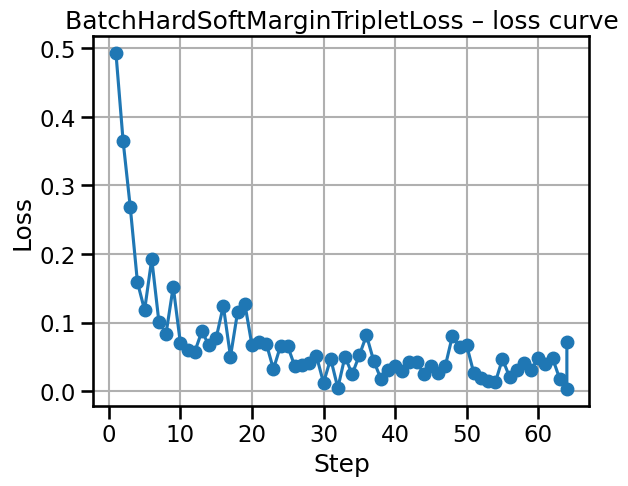

In [183]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchHardSoftMarginTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchhardsoftmargintripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchhardsoftmargintripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
    extra_feature_keys=["omics_ids"],
)
trainer.train()

plot_training_loss(trainer, title="BatchHardSoftMarginTripletLoss – loss curve")

initial  : within=0.4910   between=0.9670 sil=0.596
trained  : within=0.2552   between=1.4401   sil=0.818


<Axes: title={'center': 'after training'}, xlabel='PC1', ylabel='PC2'>

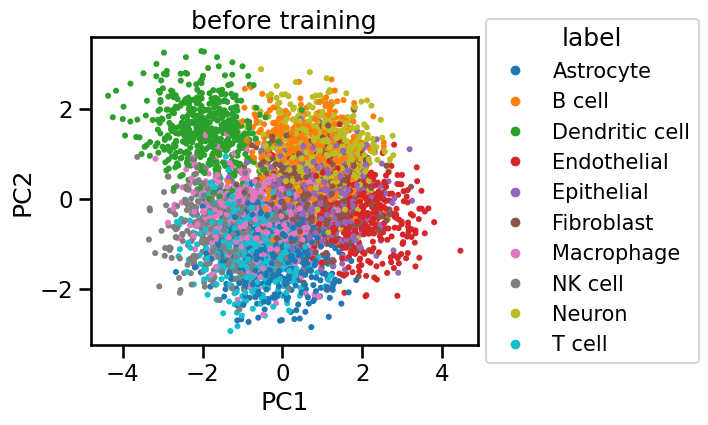

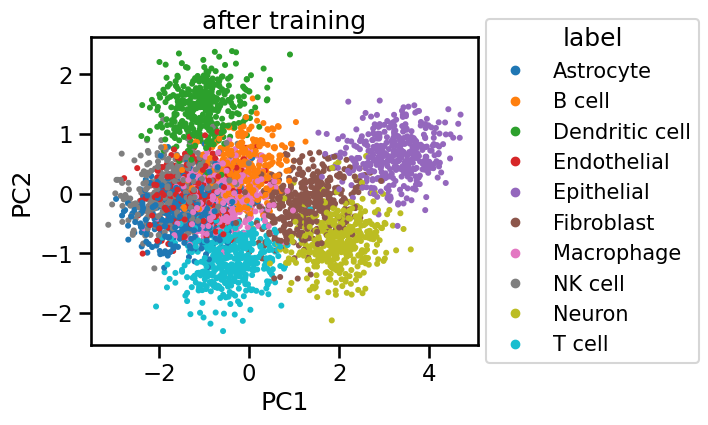

In [184]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)

## 5. Run summary (fill during execution)

In [185]:
# Users can append rows manually or programmatically here
